In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random

### this one works only through integrating the derivative

In [2]:
import sys
import os

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data

In [3]:
n_points = 200
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="equally_spaced"
initial_state = jnp.array([0.0, 1.0])

t, y, y_noisy, true_derivatives = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

spacing_type="chebyshev"
t_cheb, y_cheb, y_noisy_cheb, true_derivatives_cheb = generate_ode_data(n_points, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [4]:
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'TriangularKernel', bandwidth=0.6)
estimated_derivative_cheb, estimated_solution_cheb = collocate_data(y_noisy_cheb, t_cheb, 'TriangularKernel', bandwidth=0.6)

In [118]:
def interpolate(x, y, x_new):
    """
    Interpolate a function through the points (x, y) and evaluate it at x_new.
    """
    return jnp.interp(x_new, x, y)

# Define a wrapper function to compute the interpolated values
def interpolated_function(x_new, x, y):
    return interpolate(x, y, x_new)

# Define a function to compute the derivatives at the points x
def compute_derivative(x, y):
    """
    Compute the derivative of y with respect to x using interpolation and JAX's automatic differentiation.
    """
    # Vectorize the gradient function
    grad_interpolated_function = jax.vmap(grad(lambda x_new: interpolated_function(x_new, x, y)))
    
    # Compute the gradient at each point in x
    dydx = grad_interpolated_function(x)
    
    return dydx

# Compute the derivative
dydx = compute_derivative(t, estimated_solution[0])

Loss equal: 27.673
Loss Chebyshev: 37.481


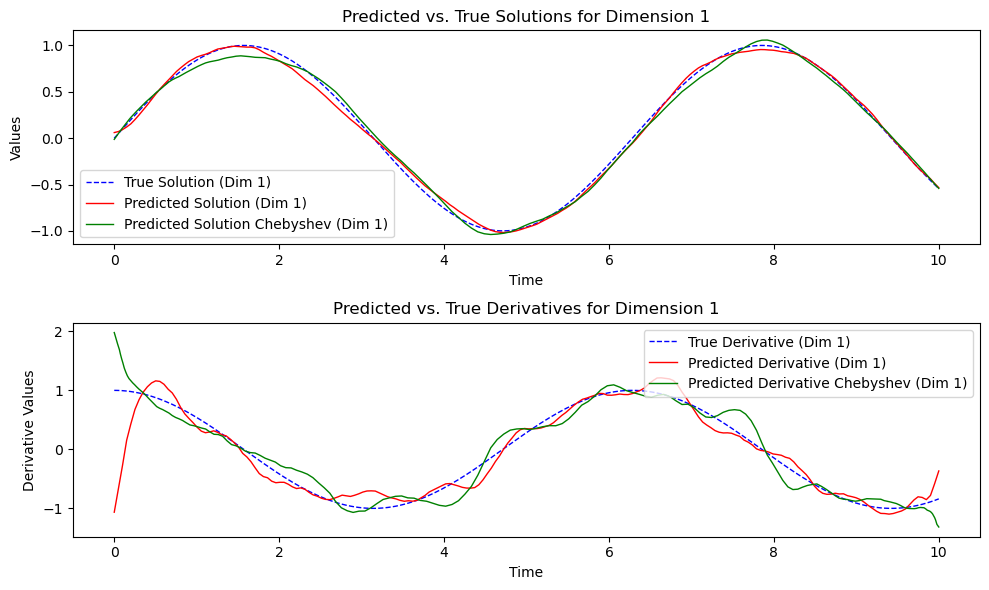

In [119]:
plt.figure(figsize=(10, 6))

# Subplot 1: Solutions
plt.subplot(2, 1, 1)  
plt.plot(t, y[:, 0], 'b--', linewidth=1, label='True Solution (Dim 1)')
plt.plot(t, estimated_solution[0], 'r-', linewidth=1, label='Predicted Solution (Dim 1)')
plt.plot(t_cheb, estimated_solution_cheb[0], 'g-', linewidth=1, label='Predicted Solution Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Predicted vs. True Solutions for Dimension 1')
plt.legend()

# Subplot 2: Derivatives
plt.subplot(2, 1, 2)  
plt.plot(t, true_derivatives[:, 0], 'b--', linewidth=1, label='True Derivative (Dim 1)')
# plt.plot(t, dydx, 'y--', linewidth=1, label='Predicted Derivative (Dim 1)')
plt.plot(t, estimated_derivative[0], 'r-', linewidth=1, label='Predicted Derivative (Dim 1)')
plt.plot(t_cheb, estimated_derivative_cheb[0], 'g-', linewidth=1, label='Predicted Derivative Chebyshev (Dim 1)')
plt.xlabel('Time')
plt.ylabel('Derivative Values')
plt.title('Predicted vs. True Derivatives for Dimension 1')
plt.legend()

print(f"Loss equal: {jnp.sum(jnp.abs(true_derivatives.T[0] - estimated_derivative[0])):.3f}")
print(f"Loss Chebyshev: {jnp.sum(jnp.abs(true_derivatives_cheb.T[0] - estimated_derivative_cheb[0])):.3f}")

plt.tight_layout() 
plt.show()


In [145]:
# Define the neural network with Flax
class ODEFunc(nn.Module):
    @nn.compact
    def __call__(self, y, t):
        t = jnp.expand_dims(t, axis=-1)
        y = jnp.expand_dims(y, axis=-1)
        y = jnp.concatenate([y, t], axis=-1)
        y = nn.Dense(features=50)(y)
        y = nn.relu(y)
        y = nn.Dense(features=50)(y)
        y = nn.relu(y)
        y = nn.Dense(features=1)(y)
        return y

# Initialize model
def create_model():
    return ODEFunc()

# Define the loss function
def loss_fn(params, apply_fn, y, t, true_dy_dt):
    def ode_rhs(y, t):
        return apply_fn({'params': params}, y, t)
    
    pred_dy_dt = ode_rhs(y, t)
    loss = jnp.mean(jnp.abs(pred_dy_dt - true_dy_dt))
    return loss

# Training step
@jax.jit
def train_step(state, y, t, true_dy_dt):
    loss, grads = jax.value_and_grad(loss_fn)(state.params, state.apply_fn, y, t, true_dy_dt)
    state = state.apply_gradients(grads=grads)
    return state, loss

# Training loop
def train_model(t, y, estimated_derivative):
    rng = random.PRNGKey(0)
    model = create_model()
    params = model.init(rng, jnp.ones((1,)), jnp.ones((1,)))['params']
    tx = optax.adam(learning_rate=0.001)
    state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

    for epoch in range(2000):
        for i in range(len(t)):
            state, loss = train_step(state, y[i], t[i], estimated_derivative[i])
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return state

# Predict derivatives using the trained model
def predict_derivatives(state, t, y):
    pred_dy_dt = []
    for i in range(len(t)):
        dy_dt = state.apply_fn({'params': state.params}, y[i], t[i])
        pred_dy_dt.append(dy_dt)
    return jnp.array(pred_dy_dt)

# Train the model
trained_state = train_model(t, y_noisy[0], estimated_derivative[0])

Epoch 0, Loss: 0.3233916163444519
Epoch 100, Loss: 0.5832433700561523
Epoch 200, Loss: 0.973236083984375
Epoch 300, Loss: 0.8791764974594116
Epoch 400, Loss: 0.8291672468185425
Epoch 500, Loss: 0.7896970510482788
Epoch 600, Loss: 0.7042003870010376
Epoch 700, Loss: 0.6698321104049683
Epoch 800, Loss: 0.6477795839309692
Epoch 900, Loss: 0.6222328543663025
Epoch 1000, Loss: 0.6179072856903076
Epoch 1100, Loss: 0.6307029724121094
Epoch 1200, Loss: 0.6419881582260132
Epoch 1300, Loss: 0.6256897449493408
Epoch 1400, Loss: 0.6045761108398438
Epoch 1500, Loss: 0.6326273679733276
Epoch 1600, Loss: 0.5990829467773438
Epoch 1700, Loss: 0.5327293872833252
Epoch 1800, Loss: 0.46704280376434326
Epoch 1900, Loss: 0.38718390464782715


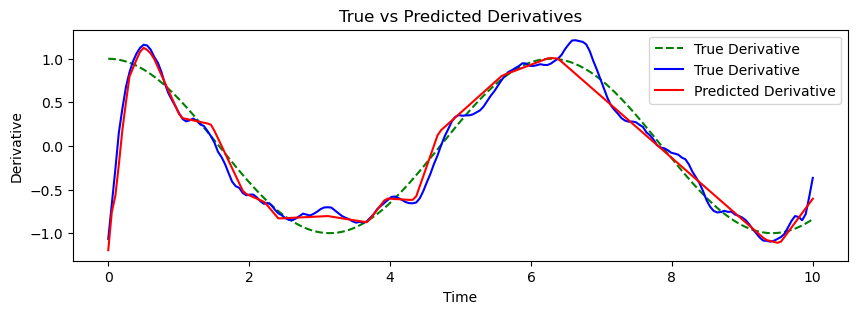

In [ ]:
# Generate predictions
pred_dy_dt = predict_derivatives(trained_state, t, y_noisy[0])

# Plot true vs predicted derivatives
plt.figure(figsize=(10, 3))
plt.plot(t, true_derivatives.T[0], label='True Derivative', color='green', linestyle='dashed')
plt.plot(t, estimated_derivative[0], label='True Derivative', color='blue')
plt.plot(t, pred_dy_dt, label='Predicted Derivative', color='red')
plt.xlabel('Time')
plt.ylabel('Derivative')
plt.title('True vs Predicted Derivatives')
plt.legend()
plt.show()


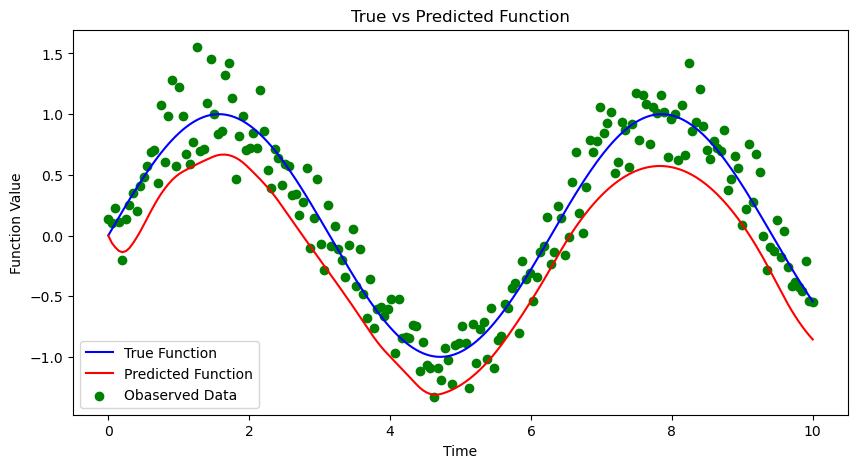

In [147]:
def integrate_derivative(t, dy_dt, y0):
    y = jnp.zeros_like(dy_dt)
    y = y.at[0].set(y0)
    for i in range(1, len(dy_dt)):
        dt = t[i] - t[i - 1]
        y = y.at[i].set(y[i - 1] + dy_dt[i - 1] * dt)
    return y


# Reconstruct the function from the predicted derivatives
y0 = y[0][0]  # Initial condition
y_pred = integrate_derivative(t, pred_dy_dt, y0)

# Plot true vs predicted function
plt.figure(figsize=(10, 5))
plt.plot(t, y.T[0], label='True Function', color='blue')
plt.plot(t, y_pred, label='Predicted Function', color='red')
plt.scatter(t, y_noisy.T[0], label='Obaserved Data', color='green')
plt.xlabel('Time')
plt.ylabel('Function Value')
plt.title('True vs Predicted Function')
plt.legend()
plt.show()